<div style="text-align:center; background-color:#f0f0f0; padding:20px; border-radius:10px;">
    <h1 style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color:#333; font-size:3em; font-weight:bold;">Data-related Innovation in Finance</h1>
    <p style="font-family: 'Garamond', serif; font-size:1.5em; color:#555; margin-top:0;">Personal Analysis of Stocks & Cryptocurrencies</p>
    <p style="font-family: 'Arial', sans-serif; font-size:1.2em; color:#777; margin-top:0;">Author: Antoine BUFFANDEAU</p>
</div>

<div class="alert alert-block alert-info" style = "font-family: Cambria Math;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 1.0px; padding: 3.5px" >
The rendering (display/design) of this notebbok <b>doesn't function</b> properly on </b>Google Collab!</b>  
Please open it on Visual Studio Code for better rendering.
</div>

<div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466">

## TABLE OF CONTENTS

</div>

* [PACKAGE IMPORTS](#1)
* [FUNCTIONS](#2)
* [Network Analysis of Stocks](#3)
    * [Import of historical data for CAC40 components from 2018 to 2023](#3a)
* [Network Analysis of Cryptocurrencies](#4)
* [Modelling and Assessing Financial Contagion and Stability](#5)

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">PACKAGE IMPORTS<br></div>

In [300]:
import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [301]:
print("Numpy version:",np.__version__)
print("Pandas version:", pd.__version__)
print("Yahoo Finance version:", yf.__version__)
print("NetWorkX:", nx.__version__)
print("Seaborn version:", sns.__version__)

Numpy version: 1.26.4
Pandas version: 2.2.1
Yahoo Finance version: 0.2.44
NetWorkX: 3.3
Seaborn version: 0.13.2


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">FUNCTIONS<br></div>

In [302]:
def plot_heatmap(matrix, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, annot=False, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

def stronger_corr(matrix):
    corr_pairs = matrix.unstack()
    filtered_corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
    sorted_corr_pairs = filtered_corr_pairs.sort_values(ascending=False)
    top_10_correlations = sorted_corr_pairs.head(10)
    print("Top 10 strongest correlations:")
    print(top_10_correlations)

In [303]:
def plot_times_series(matrix):
    # Plot the close prices:
    # Line plot
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.lineplot(matrix)

    # Formatting
    ax.set_title('Close Price Index (DAX30 Stocks)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Time (format \'yyyy\')', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Price Index (in EUR)', fontsize = 16, fontdict=dict(weight='bold'))

    # Adjusting tick label sizes for better readability
    plt.tick_params(axis='y', which='major', labelsize=16)
    plt.tick_params(axis='x', which='major', labelsize=16)
    ax.get_legend().set_visible(True)
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    plt.show()

def trading_volumes(matrix):
    # Plot the trading volumes:
    # Line plot
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.lineplot(matrix)

    # Formatting
    ax.set_title('Trading Volume (DAX30 Stocks)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Time', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Trading Volume', fontsize = 16, fontdict=dict(weight='bold'))

    # Adjusting tick label sizes for better readability
    plt.tick_params(axis='y', which='major', labelsize=16)
    plt.tick_params(axis='x', which='major', labelsize=16)
    ax.get_legend().set_visible(True)
    plt.legend(loc = "upper left", bbox_to_anchor=(1, 1))
    plt.show()

<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff">Network Analysis of Stocks<br></div>

<a id="3a"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">Import of historical data for CAC40 components from 2018 to 2023<br></div>

| Companies                        | Ticker Yahoo       | 2018 | 2019 | 2020 | 2021 | 2022 | 2023 | 2024 |
|------------------------------------|--------------------|------|------|------|------|------|------|------|
| Accor                              | AC.PA              | X    | X    | X    | X    | X    | X    | X    |
| Airbus                             | AIR.PA             | X    | X    | X    | X    | X    | X    | X    |
| Air Liquide                        | AI.PA              | X    | X    | X    | X    | X    | X    | X    |
| Alstom                             | ALO.PA             | X    | X    | X    | X    | X    | X    | X    |
| ArcelorMittal                      | MT.AS              | X    | X    | X    | X    |      |      |      |
| Atos                               | ATO.PA             | X    | X    | X    | X    |      |      |      |
| Axa                                | CS.PA              | X    | X    | X    | X    | X    | X    | X    |
| BNP Paribas                        | BNP.PA             | X    | X    | X    | X    | X    | X    | X    |
| Bouygues                           | EN.PA              | X    | X    | X    | X    | X    | X    | X    |
| Capgemini                          | CAP.PA             | X    | X    | X    | X    | X    | X    | X    |
| Carrefour                          | CA.PA              | X    | X    | X    | X    | X    | X    | X    |
| Crédit Agricole                    | ACA.PA             | X    | X    | X    | X    | X    | X    | X    |
| Danone                             | BN.PA              | X    | X    | X    | X    | X    | X    | X    |
| Dassault Systèmes                  | DSY.PA             | X    | X    | X    | X    | X    | X    | X    |
| Engie                              | ENGI.PA            | X    | X    | X    | X    | X    | X    | X    |
| Essilor/EssilorLuxottica           | EL.PA              | X    | X    | X    | X    | X    | X    | X    |
| Hermès                             | RMS.PA             | X    | X    | X    | X    | X    | X    | X    |
| Kering                             | KER.PA             | X    | X    | X    | X    | X    | X    | X    |
| L’Oréal                            | OR.PA              | X    | X    | X    | X    | X    | X    | X    |
| Legrand                            | LR.PA              | X    | X    | X    | X    | X    | X    | X    |
| LVMH                               | MC.PA              | X    | X    | X    | X    | X    | X    | X    |
| Michelin                           | ML.PA              | X    | X    | X    | X    | X    | X    | X    |
| Orange                             | ORA.PA             | X    | X    | X    | X    | X    | X    | X    |
| Pernod Ricard                      | RI.PA              | X    | X    | X    | X    | X    | X    | X    |
| Peugeot                            | UG.PA              | X    |      |      |      |      |      |      |
| Publicis                           | PUB.PA             | X    | X    | X    | X    | X    | X    | X    |
| Renault                            | RNO.PA             | X    | X    | X    | X    | X    | X    | X    |
| Safran                             | SAF.PA             | X    | X    | X    | X    | X    | X    | X    |
| Saint-Gobain                       | SGO.PA             | X    | X    | X    | X    | X    | X    | X    |
| Sanofi                             | SAN.PA             | X    | X    | X    | X    | X    | X    | X    |
| Schneider Electric                 | SU.PA              | X    | X    | X    | X    | X    | X    | X    |
| Société Générale                   | GLE.PA             | X    | X    | X    | X    | X    | X    | X    |
| Solvay                             | SOLB.BR            | X    | X    |      |      |      |      |      |
| STMicroelectronics                 | STMPA.PA             | X    | X    | X    | X    | X    | X    | X    |
| TechnipFMC                         | FTI.PA             | X    | X    | X    |      |      |      |      |
| Thales                             | HO.PA              | X    | X    | X    | X    | X    | X    | X    |
| Total/TotalEnergies                | TTE.PA             | X    | X    | X    | X    | X    | X    | X    |
| Unibail-Rodamco-Westfield          | URW.PA             | X    | X    | X    | X    | X    | X    | X    |
| Valeo                              | FR.PA              | X    | X    | X    | X    | X    | X    | X    |
| Veolia                             | VIE.PA             | X    | X    | X    | X    | X    | X    | X    |
| Vinci                              | DG.PA              |      | X(N) | X    | X    | X    | X    | X    |
| Worldline                          | WLN.PA             |      |      | X(N) | X    | X    | X    | X    |
| Teleperformance                    | TEP.PA             |      |      | X(N) | X    | X    | X    | X    |
| Eurofins Scientific                | ERF.PA             |      |      |      | X(N) | X    | X    | X    |
| Stellantis                         | STLA.PA            |      |      |      |      | X(N) | X    | X    |


Comments : 

X : Indicates that the company was part of the CAC40 in that year ;

(N) : Indicates that a company entered the CAC40 for that year.

In [304]:
#I have arbitrarily chosen here to select only the stock names that remained in the CAC40 list from 2018 to 2023.
cac40_tickers = [
    'AC.PA',   # Accor
    'AI.PA',   # Air Liquide
    'AIR.PA',  # Airbus
    'ALO.PA',  # Alstom
    'BNP.PA',  # BNP Paribas
    'EN.PA',   # Bouygues
    'CAP.PA',  # Capgemini
    'CA.PA',   # Carrefour
    'ACA.PA',  # Crédit Agricole
    'BN.PA',   # Danone
    'DSY.PA',  # Dassault Systèmes
    'ENGI.PA', # Engie
    'EL.PA',   # EssilorLuxottica
    'RMS.PA',  # Hermès
    'KER.PA',  # Kering
    'OR.PA',   # L'Oréal
    'LR.PA',   # Legrand
    'MC.PA',   # LVMH
    'ML.PA',   # Michelin
    'ORA.PA',  # Orange
    'PUB.PA',  # Publicis
    'RI.PA',   # Pernod Ricard
    'SGO.PA',  # Saint-Gobain
    'SAN.PA',  # Sanofi
    'SU.PA',   # Schneider Electric
    'GLE.PA',  # Société Générale
    'STMPA.PA',  # STMicroelectronics
    'HO.PA',   # Thales
    'URW.PA',  # Unibail-Rodamco-Westfield
    'FR.PA',   # Valeo
    'VIE.PA',  # Veolia
]

In [305]:
data = yf.download(cac40_tickers, start='2018-01-01', end='2023-12-31')
data.shape  #should have: 31*6 columns ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] and less than 365*5 lines (because of workdays)

[*********************100%***********************]  31 of 31 completed


(1538, 186)

In [306]:
data.shape

(1538, 186)

In [307]:
data.head()

Price                      Adj Close                                  \
Ticker                         AC.PA    ACA.PA      AI.PA     AIR.PA   
Date                                                                   
2018-01-02 00:00:00+00:00  39.639462  8.694453  68.072723  77.157585   
2018-01-03 00:00:00+00:00  39.484482  8.747355  68.593857  78.434998   
2018-01-04 00:00:00+00:00  39.748863  9.142557  70.157249  80.020119   
2018-01-05 00:00:00+00:00  39.903847  9.126998  70.743530  79.814972   
2018-01-08 00:00:00+00:00  40.459965  9.226577  71.525223  80.766052   

Price                                                                  \
Ticker                        ALO.PA      BN.PA     BNP.PA      CA.PA   
Date                                                                    
2018-01-02 00:00:00+00:00  27.346344  54.851501  37.975788  14.595326   
2018-01-03 00:00:00+00:00  27.684729  55.217331  38.312183  14.639627   
2018-01-04 00:00:00+00:00  27.960159  56.036491  39.003319  14.756420   
2018-01-05 00:00:00+00:00  28.251328  57.062412  39.076714  14.913490   
2018-01-08 00:00:00+00:00  28.290678  56.680679  39.449806  14.450337   

Price                                            ...   Volume                  \
Ticker                        CAP.PA     DSY.PA  ...   ORA.PA  PUB.PA   RI.PA   
Date                                             ...                            
2018-01-02 00:00:00+00:00  88.655785  17.082813  ...  5623409  723777  327359   
2018-01-03 00:00:00+00:00  90.446815  17.291754  ...  5713414  936153  331727   
2018-01-04 00:00:00+00:00  90.760239  17.338182  ...  7180972  934769  412113   
2018-01-05 00:00:00+00:00  91.790085  17.516172  ...  5739730  827513  431872   
2018-01-08 00:00:00+00:00  91.700531  17.539385  ...  4569150  660005  439856   

Price                                                                        \
Ticker                    RMS.PA   SAN.PA   SGO.PA STMPA.PA    SU.PA URW.PA   
Date                                                                          
2018-01-02 00:00:00+00:00  36036  2251997  1271328  1774856  1173030    NaN   
2018-01-03 00:00:00+00:00  24416  2178460  2049422  2211658  1245073    NaN   
2018-01-04 00:00:00+00:00  39774  2753081  1728114  2546492  1384025    NaN   
2018-01-05 00:00:00+00:00  40301  2582924  1207486  1948360  1126714    NaN   
2018-01-08 00:00:00+00:00  37191  1847656  1265243  2064515  1169355    NaN   

Price                               
Ticker                      VIE.PA  
Date                                
2018-01-02 00:00:00+00:00  1348972  
2018-01-03 00:00:00+00:00  2210552  
2018-01-04 00:00:00+00:00  1977720  
2018-01-05 00:00:00+00:00  1885498  
2018-01-08 00:00:00+00:00  1561941  

[5 rows x 186 columns]

In [308]:
nan_count = data.isna().sum()
nan_count_filtered = nan_count[nan_count > 0]
print("Stocks with NaN values:", nan_count_filtered)

Stocks with NaN values: Price      Ticker
Adj Close  URW.PA    1355
Close      URW.PA    1355
High       URW.PA    1355
Low        URW.PA    1355
Open       URW.PA    1355
Volume     URW.PA    1355
dtype: int64


In [309]:
#data = data.drop(['URW.PA'], axis=1)
data.columns

MultiIndex([('Adj Close',    'AC.PA'),
            ('Adj Close',   'ACA.PA'),
            ('Adj Close',    'AI.PA'),
            ('Adj Close',   'AIR.PA'),
            ('Adj Close',   'ALO.PA'),
            ('Adj Close',    'BN.PA'),
            ('Adj Close',   'BNP.PA'),
            ('Adj Close',    'CA.PA'),
            ('Adj Close',   'CAP.PA'),
            ('Adj Close',   'DSY.PA'),
            ...
            (   'Volume',   'ORA.PA'),
            (   'Volume',   'PUB.PA'),
            (   'Volume',    'RI.PA'),
            (   'Volume',   'RMS.PA'),
            (   'Volume',   'SAN.PA'),
            (   'Volume',   'SGO.PA'),
            (   'Volume', 'STMPA.PA'),
            (   'Volume',    'SU.PA'),
            (   'Volume',   'URW.PA'),
            (   'Volume',   'VIE.PA')],
           names=['Price', 'Ticker'], length=186)

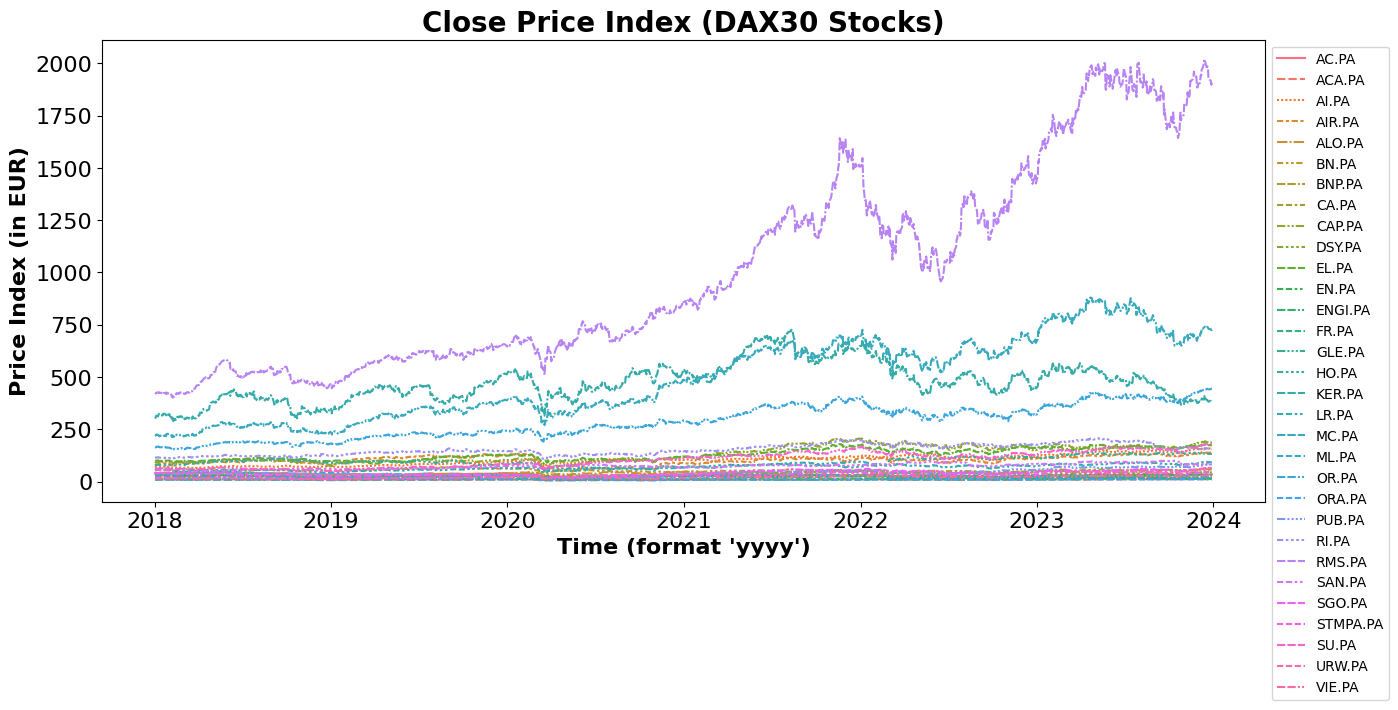

In [310]:
plot_times_series(data['Adj Close'])

In [311]:
returns = data['Adj Close'].pct_change().dropna()
correlation_matrix = returns.corr()

correlation_matrix

Ticker,AC.PA,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,DSY.PA,...,ORA.PA,PUB.PA,RI.PA,RMS.PA,SAN.PA,SGO.PA,STMPA.PA,SU.PA,URW.PA,VIE.PA
Ticker,,,,,,,,,,,,,,,,,,,,,
AC.PA,1.000000,0.315785,0.404565,0.475772,0.084823,0.118071,0.419341,0.134796,0.225546,0.325627,...,0.032763,0.376398,0.232055,0.506119,0.161882,0.448506,0.327582,0.376865,0.335826,0.345788
ACA.PA,0.315785,1.000000,0.280516,0.343709,0.175112,0.026318,0.716613,0.166481,0.266886,0.229049,...,0.031010,0.313905,0.215146,0.300133,0.079673,0.481904,0.260948,0.349685,0.415697,0.322252
AI.PA,0.404565,0.280516,1.000000,0.403133,0.156531,0.404674,0.372336,0.185080,0.264569,0.441452,...,0.198947,0.340543,0.216592,0.563229,0.144212,0.433940,0.285973,0.486387,0.194399,0.441539
AIR.PA,0.475772,0.343709,0.403133,1.000000,0.125931,0.249140,0.306169,0.139638,0.151311,0.322115,...,-0.007852,0.238656,0.077322,0.374765,0.140471,0.289329,0.187125,0.299840,0.260045,0.333841
ALO.PA,0.084823,0.175112,0.156531,0.125931,1.000000,0.029992,0.211877,0.107288,0.168567,0.122278,...,-0.008834,0.137337,0.212694,0.189778,-0.007704,0.300703,0.150669,0.256224,0.234471,0.164143
BN.PA,0.118071,0.026318,0.404674,0.249140,0.029992,1.000000,0.063283,0.217272,0.079121,0.141076,...,0.273545,0.039408,0.220832,0.215286,0.323372,0.101965,0.028966,0.149197,0.052271,0.275263
BNP.PA,0.419341,0.716613,0.372336,0.306169,0.211877,0.063283,1.000000,0.203103,0.365158,0.278019,...,0.088204,0.384067,0.303605,0.442567,0.108154,0.617818,0.399833,0.437744,0.463222,0.392263
CA.PA,0.134796,0.166481,0.185080,0.139638,0.107288,0.217272,0.203103,1.000000,0.126320,-0.025968,...,0.212820,0.184433,0.037516,0.000770,0.043106,0.250498,0.175450,0.047164,0.205306,0.288037
CAP.PA,0.225546,0.266886,0.264569,0.151311,0.168567,0.079121,0.365158,0.126320,1.000000,0.375405,...,0.035364,0.321538,0.159697,0.271252,0.177669,0.399378,0.561239,0.326604,0.325089,0.398354


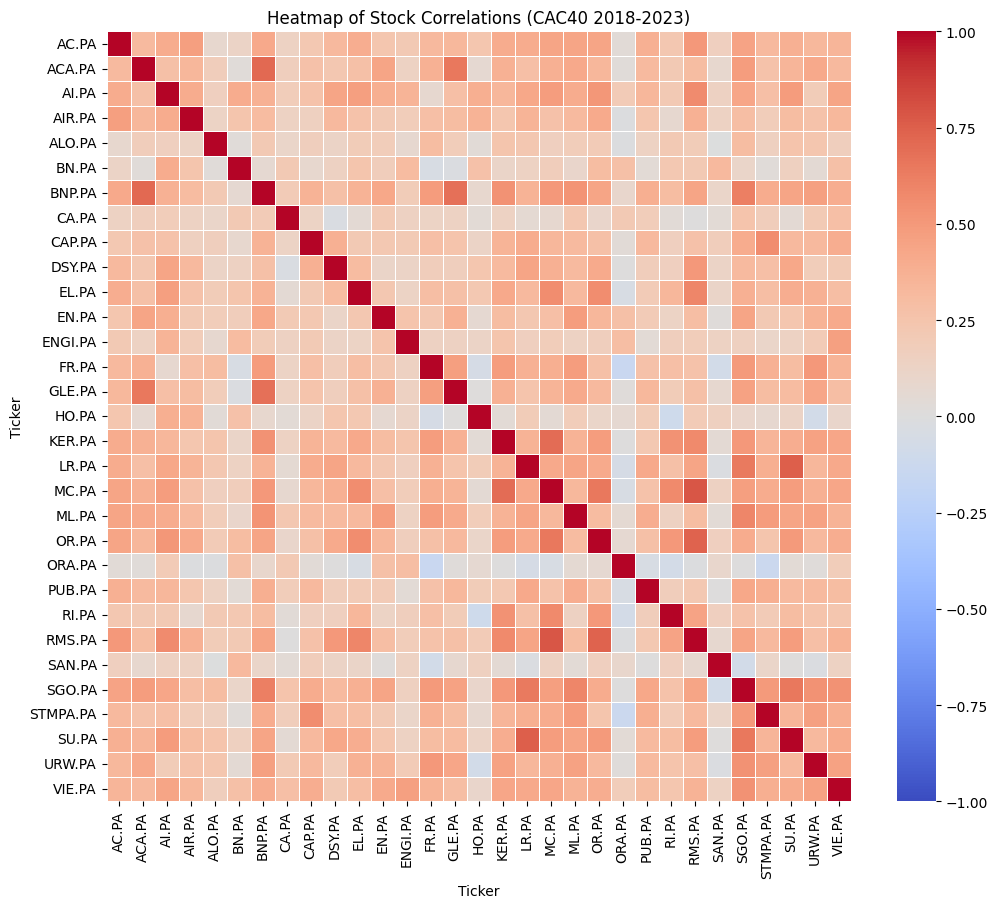

In [312]:
plot_heatmap(correlation_matrix, "Heatmap of Stock Correlations (CAC40 2018-2023)")

In [313]:
stronger_corr(correlation_matrix)

Top 10 strongest correlations:
Ticker  Ticker
RMS.PA  MC.PA     0.787993
MC.PA   RMS.PA    0.787993
SU.PA   LR.PA     0.753029
LR.PA   SU.PA     0.753029
OR.PA   RMS.PA    0.735497
RMS.PA  OR.PA     0.735497
BNP.PA  ACA.PA    0.716613
ACA.PA  BNP.PA    0.716613
MC.PA   KER.PA    0.698368
KER.PA  MC.PA     0.698368
dtype: float64


<a id="3b"></a>
## <div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left; padding:3.0px; background: #6495ED; border-bottom: 10px solid #80ffff">The Stock Network<br></div>

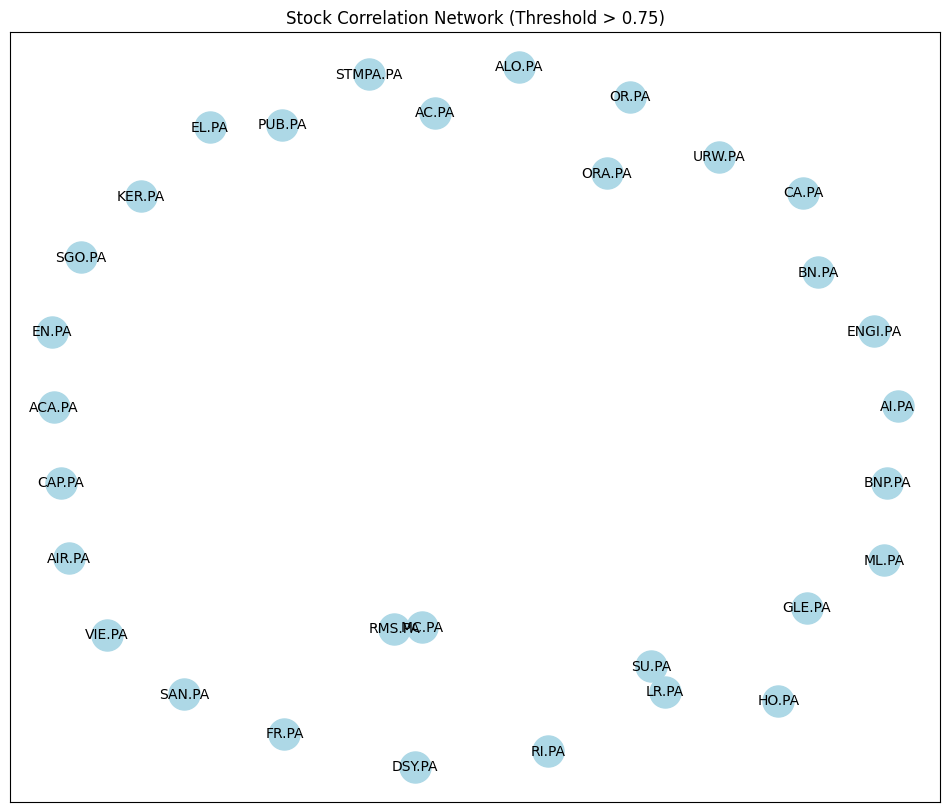

In [314]:
threshold = 0.75
G = nx.Graph()
G.add_nodes_from(correlation_matrix.columns)

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j],
                       weight=correlation_matrix.iloc[i, j])
            
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_size=500, node_color='lightblue', with_labels=True, font_size=10)
plt.title("Stock Correlation Network (Threshold > 0.75)")
plt.show()